In [4]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, f1_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler



### Load variables stored by data_preproccessing notebook

In [5]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats



### configurations
* save_plots -> True|False
* random_seed_state -> number, sets random state for model and for stratified splits 
* classify_bedrock_only -> True|False
* pickle_model -> True|False, wether model should be serialised and saved
* pickle_model_name -> string, name of serialised model
* grid_search -> True|False, if set to true then grid search is performed to identify optimum hyperparamaters for model 
* scale -> True|False if set to True then features scaled to all have mean value 0 and standard deviation 1
* pickle_file_path -> string,  filepath for serialised model to be saved to

In [18]:
save_plots = False
random_seed_state = 42
classify_bedrock_only = False
pickle_model = False
pickle_model_name = 'grouped'
pickle_file_path = '../../../model'
grid_search = True
scale = True

### if only bedrock sites are classified then classes are label encoded, if bedrock sites alone are not being classified then the class sites would have already been label encoded in the 1 data_preproccessing notebook 

In [7]:
if classify_bedrock_only:
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
    train_data_formodel = train_data_formodel[train_data_formodel['Geology']=='Bedrock']

### The class column is stored as the variable y 

In [19]:
y = np.array(train_data_formodel['class'])

### The variables identified as best by the 2 feature_selection notebook are used as features

In [20]:
train_data_feats = train_data_formodel[best_feats]

In [21]:
if scale:
    my_scaler = StandardScaler()
    X = np.array(my_scaler.fit_transform(train_data_feats))
else:
    X = np.array(train_data_feats)

In [11]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 1700, 
    'max_depth': 100,
    'min_samples_split':3,
    'min_samples_leaf': 1,
    'max_features' : 'auto',
    'verbose': 1,
    'bootstrap':True
}
'''
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':50,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 3
}


# AdaBoost parameters
ada_params = {
    'n_estimators': 50,
    'learning_rate' : 0.75
}
'''
# Gradient Boosting parameters
gb_params = {
    'booster':'gbtree',
    'n_estimators': 5000,
    'max_depth': 5,
    'min_child_weight':3,
    'verbose': 1,
    'random_seed':42
}

svc_params = {
    'C' : 1000, 
    'kernel':'linear', 
    'verbose':3, 
    'class_weight':'balanced', 
    'gamma':0.001
    }
# Support Vector Classifier parameters 

mlp_params = {'hidden_layer_sizes':(50, 200, 200), 
              'activation' :'tanh', 
              'max_iter':100000, 
              'alpha':0.1,
                'solver':'lbfgs', 
              'verbose':2, 'tol':0.0000000001, 
              'learning_rate' :'constant'
    
}
'''
knn_params = {
    'n_jobs' : -1
}

bgg_params = {
    'n_jobs' : -1,
    'n_estimators':50
}
'''

"\nknn_params = {\n    'n_jobs' : -1\n}\n\nbgg_params = {\n    'n_jobs' : -1,\n    'n_estimators':50\n}\n"

In [14]:
def f1_scorer(y_test, y_pred):
    from sklearn.metrics import f1_score
    return(f1_score(y_test, y_pred, average = 'weighted'))

In [15]:
ensemble = SuperLearner(scorer=f1_scorer, random_state=42)

In [16]:
# Build the first layer
ensemble.add([RandomForestClassifier(**rf_params), SVC(**svc_params), MLPClassifier(**mlp_params), xgb.XGBClassifier(**gb_params)])

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...3f8c268>)],
   n_jobs=-1, name='group-0', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function f1_scorer at 0x7f9103f8c268>, shuffle=False,
       verbose=False)

In [17]:
# Attach the final meta estimator

ensemble.add_meta(xgb.XGBClassifier(**gb_params))

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...3f8c268>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function f1_scorer at 0x7f9103f8c268>, shuffle=False,
       verbose=False)

In [22]:
%%time
esti = MLPClassifier(hidden_layer_sizes=(50, 200, 200), activation = 'tanh', max_iter=300000, alpha=0.1,
                    solver='lbfgs', verbose=3,  random_state=random_seed_state,tol=0.000000000001, learning_rate  ='constant')
skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)
skf.get_n_splits(X, y)
class_f1_scores = []
macro_f1_scores = []
accuracy_scores = []
feat_imp =[]
f1_dict = {}
feat_imp_dict = {}
count = 0
for train_index, test_index in skf.split(X, y):
    count = count + 1
    print('making model:')
    key = 'round' + str(count)
    print(count)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    esti.fit(X_train, y_train)
    y_pred = esti.predict(X_test)
    class_f1_scores = f1_score(y_test, y_pred, average = None)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(f1_score(y_test, y_pred, average = 'weighted'))
    f1_dict[key] = class_f1_scores 
    #feat_imp_dict[key] = esti.feature_importances_

making model:
1
making model:
2


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
3
making model:
4
making model:
5


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
6


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
7
making model:
8
making model:
9


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
10
CPU times: user 52min 22s, sys: 1min 46s, total: 54min 9s
Wall time: 13min 37s


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
f1_df = pd.DataFrame(data = f1_dict)


In [14]:
for key in f1_dict:
    print(len(f1_dict[key]))

23
23
23
23
23
23
23
23
23
23


### Below are the encodings for the class variable

In [15]:
print(train_data_formodel['class'].unique())
print(list(uniques))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
['FH', 'ER', 'WW', 'TC', 'CS', 'KQ', 'AR', 'SL', 'FG', 'WB_BX', 'PF', 'WH', 'SQ', 'WN', 'BH', 'PH', 'LB', 'AB', 'LV', 'SV_SE', 'BA', 'WA', 'MM']


In [16]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [17]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

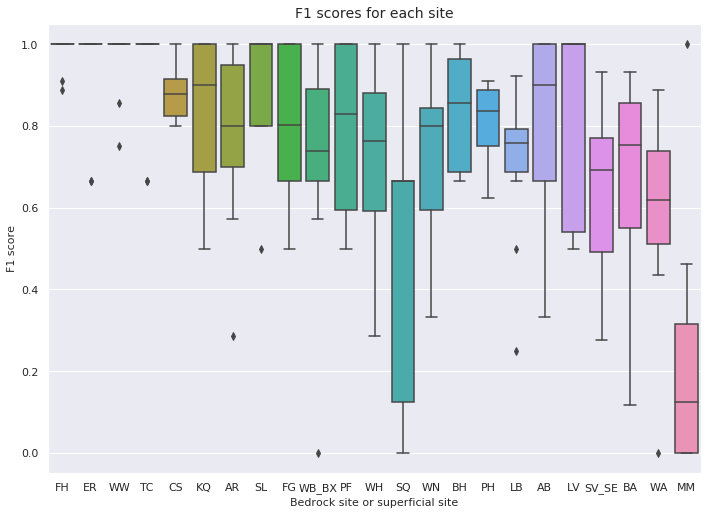

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Bedrock site or superficial site", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/site_specific_f1_scores.png')

In [19]:
pd.DataFrame(data = f1_df_final.T.median()).to_csv('output/median_class_f1_scores.csv')

### Boxplot showing the macro F1 score with weighted averages

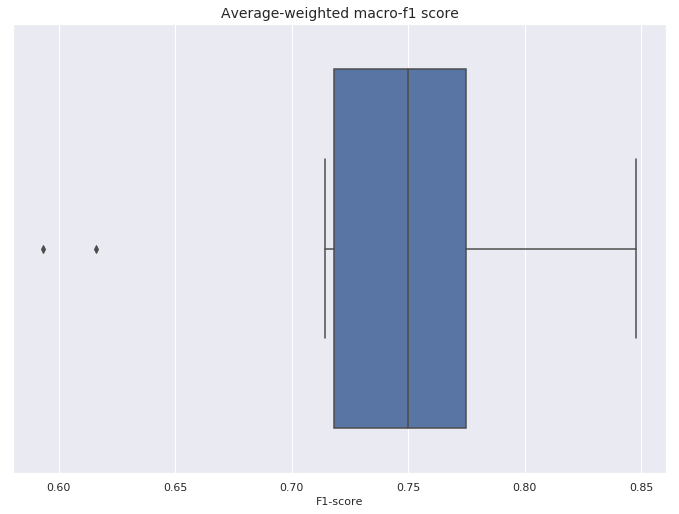

In [20]:
plot = sns.boxplot(macro_f1_scores)
plot.set_title('Average-weighted macro-f1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/macro_f1_scores.png')